In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import janitor 

from influxdb_client import InfluxDBClient, Point, Dialect

import re

import time
import datetime

import warnings
from influxdb_client.client.warnings import MissingPivotFunction

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import matplotlib.colors as colors

# try:
#     # for Python2
#     from Tkinter import *   ## notice capitalized T in Tkinter 
# except ImportError:
#     # for Python3
#     from tkinter import *   ## notice lowercase 't' in tkinter here

pd.set_option('display.max_rows', 500)
import pandasql as ps
import sqlite3

In [2]:
#Read config file and load data into the variables

rx_dict = {
    'token': re.compile(r'var token = "(?P<token>.*)"\n'),
    'url': re.compile(r'var url = "(?P<url>.*)"\n'),
    'org': re.compile(r'var org = "(?P<org>.*)"\n'),
    'bucket': re.compile(r'var bucket = "(?P<bucket>.*)"\n'),
}

def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex

    """
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None



filepath = '/root/flexi-pipe/config.go'
# open the file and read through it line by line
with open(filepath, 'r') as file_object:
    line = file_object.readline()
    while line:
        # at each line check for a match with a regex
        key, match = _parse_line(line)

        if key == 'token':
            token = match.group('token')
        elif key == 'url':
            url = match.group('url')
        elif key == 'org':
            org = match.group('org')
        elif key == 'bucket':
            bucket = match.group('bucket')
        
        line = file_object.readline()


url="http://192.168.20.62:8086"

In [3]:
client = InfluxDBClient(url=url, token=token, org=org,  timeout=900_000)

# write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

In [16]:
# Retrieve experiments data from csv
data = pd.read_csv('../experiments.csv', header=None)
df = pd.DataFrame(data)

#Rename columns
experiments = df.rename(columns={0: "start", 1: "end", 2: "topology", 3: "runtime", 4: "parameter", 5: "d", 6: "dlo", 7: "dhi", 8: "dscore", 9: "dlazy", 10: "dout", 11: "gossipFactor", 12: "initialDelay", 13: "interval"}, errors='raise')

#Correct timestamp
experiments["start"] = experiments["start"].str.slice(0, 27)
experiments["end"] = experiments["end"].str.slice(0, 27)

#String to timestamp
# experiments['startUnix'] = pd.to_datetime(experiments["start"],format="%Y-%m-%d %H:%M:%S.%f").astype('int64') / 10**9
# experiments['endUnix'] = pd.to_datetime(experiments["end"],format="%Y-%m-%d %H:%M:%S.%f").astype('int64') / 10**9

experiments['startUnix'] = pd.to_datetime(experiments["start"],format="mixed").astype('int64') / 10**9
experiments['endUnix'] = pd.to_datetime(experiments["end"],format="mixed").astype('int64') / 10**9

experiments['startUnix'] = pd.to_timedelta(experiments['startUnix'], unit='s').dt.total_seconds().astype(int)#.astype(str)
experiments['endUnix'] = pd.to_timedelta(experiments['endUnix'], unit='s').dt.total_seconds().astype(int)#.astype(str)

#Drop fields we don't mneed for the moment
exp = experiments.drop(columns=["runtime", "initialDelay"]).sort_values(by=["start"])

# exp.loc[exp["topology"] == "general"].loc[exp["start"] >= "2023-08-25 00:00:00.5502855"].head(200)
exp.head(500)


,start,end,topology,parameter,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,startUnix,endUnix
0,2023-08-21 12:48:22.3741823,2023-08-21 13:18:22.3952804,unl,reference,8,6,12,4,8,2,0.25,1.0,1692622102,1692623902
1,2023-08-21 13:21:55.6321388,2023-08-21 13:51:55.6334369,unl,reference,8,6,12,4,8,2,0.25,1.0,1692624115,1692625915
2,2023-08-21 13:55:28.9783578,2023-08-21 14:25:28.9820206,unl,reference,8,6,12,4,8,2,0.25,1.0,1692626128,1692627928
3,2023-08-21 14:29:02.5866046,2023-08-21 14:59:02.6871797,unl,interval,8,6,12,4,8,2,0.25,0.5,1692628142,1692629942
4,2023-08-21 15:02:35.9708968,2023-08-21 15:32:36.0272486,unl,interval,8,6,12,4,8,2,0.25,0.5,1692630155,1692631956
5,2023-08-21 15:36:09.3380555,2023-08-21 16:06:09.3391894,unl,interval,8,6,12,4,8,2,0.25,0.5,1692632169,1692633969
6,2023-08-21 16:09:43.1463718,2023-08-21 16:39:43.1814633,unl,interval,8,6,12,4,8,2,0.25,30.0,1692634183,1692635983
7,2023-08-21 16:43:16.7045785,2023-08-21 17:13:16.7785160,unl,interval,8,6,12,4,8,2,0.25,30.0,1692636196,1692637996
8,2023-08-21 17:16:50.1424767,2023-08-21 17:46:50.1924402,unl,interval,8,6,12,4,8,2,0.25,30.0,1692638210,1692640010
9,2023-08-21 17:50:23.0310174,2023-08-21 18:20:23.0333186,unl,interval,8,6,12,4,8,2,0.25,3.0,1692640223,1692642023


In [12]:
#Get times for different intervals
# intervals = exp["interval"].drop_duplicates().sort_values().reset_index(drop=True)
# intervals.head(10)

expTime = exp[exp['startUnix'].astype(int).between(1692622102, 1692772911)]

reference = expTime.loc[expTime["parameter"] == "reference"]
start_reference = reference["startUnix"].min().astype(int)
end_reference = reference["endUnix"].max().astype(int)
print(start_reference)
print(end_reference)

expTime = exp.reset_index().rename({'index':'experiment'}, axis = 'columns')

# expTime.head(100)

AttributeError: 'float' object has no attribute 'astype'

In [5]:
data_frame = query_api.query_data_frame('from(bucket: "gs") '
                                        ' |> range(start: 1692374328, stop:1692398272) '
                                        ' |> filter(fn: (r) => r._measurement == "message") '
                                        ' |> group(columns: ["_measurement", "_field"], mIf tode: "by") '
                                        ' |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")')
client.close()
data_frame.head(10)

,result,table,_start,_stop,_time,_measurement,type
0,_result,0,2023-08-18 15:58:48+00:00,2023-08-18 22:37:52+00:00,2023-08-18 16:13:03.904558+00:00,message,9.0
1,_result,0,2023-08-18 15:58:48+00:00,2023-08-18 22:37:52+00:00,2023-08-18 16:13:03.904637+00:00,message,9.0
2,_result,0,2023-08-18 15:58:48+00:00,2023-08-18 22:37:52+00:00,2023-08-18 16:13:03.904686+00:00,message,9.0
3,_result,0,2023-08-18 15:58:48+00:00,2023-08-18 22:37:52+00:00,2023-08-18 16:13:03.904746+00:00,message,9.0
4,_result,0,2023-08-18 15:58:48+00:00,2023-08-18 22:37:52+00:00,2023-08-18 16:13:03.904829+00:00,message,9.0
5,_result,0,2023-08-18 15:58:48+00:00,2023-08-18 22:37:52+00:00,2023-08-18 16:13:03.904874+00:00,message,9.0
6,_result,0,2023-08-18 15:58:48+00:00,2023-08-18 22:37:52+00:00,2023-08-18 16:13:03.910452+00:00,message,4.0
7,_result,0,2023-08-18 15:58:48+00:00,2023-08-18 22:37:52+00:00,2023-08-18 16:13:03.910906+00:00,message,6.0
8,_result,0,2023-08-18 15:58:48+00:00,2023-08-18 22:37:52+00:00,2023-08-18 16:13:03.911125+00:00,message,4.0
9,_result,0,2023-08-18 15:58:48+00:00,2023-08-18 22:37:52+00:00,2023-08-18 16:13:03.912492+00:00,message,4.0


In [16]:
graph_par = pd.read_csv('../graphs_parameters.csv')
start_reference = graph_par.loc[exp["parameter"] == 

graph_par.head(10)

,measurement,measurement_name,topology,parameter,parameter_name,grouping_key
0,duplicateMessage,Message Overhead,general,interval,Heartbeat,messageID
1,duplicateMessage,Message Overhead,general,d,D,messageID
2,duplicateMessage,Message Overhead,general,dlo,Dlo,messageID
3,duplicateMessage,Message Overhead,general,dscore,Dscore,messageID
4,duplicateMessage,Message Overhead,general,dlazy,Dlazy,messageID
5,duplicateMessage,Message Overhead,general,gossipFactor,Gossip Factor,messageID
6,deliverMessage,Messages,general,interval,Heartbeat,messageID
7,deliverMessage,Messages,general,d,D,messageID
8,deliverMessage,Messages,general,dlo,Dlo,messageID
9,deliverMessage,Messages,general,dscore,Dscore,messageID


In [22]:
# df = data_frame.drop(columns=['result', 'table','_start', '_stop', '_measurement', 'topic', 'receivedFrom']).sort_values(by=["_time"]).reset_index(drop=True)
# df["_time"] = pd.to_datetime(df["_time"])
df = data_frame[['_time', "type"]].sort_values(by=["_time"]).reset_index(drop=True)
df["_time"] = pd.to_datetime(df["_time"])

df.head(10)

,_time,type
0,2023-08-14 12:28:51.289026+00:00,9.0
1,2023-08-14 12:28:51.317897+00:00,9.0
2,2023-08-14 12:28:51.325214+00:00,4.0
3,2023-08-14 12:28:51.325395+00:00,4.0
4,2023-08-14 12:28:51.325475+00:00,6.0
5,2023-08-14 12:28:51.325576+00:00,6.0
6,2023-08-14 12:28:51.360182+00:00,9.0
7,2023-08-14 12:28:51.361231+00:00,9.0
8,2023-08-14 12:28:51.366911+00:00,4.0
9,2023-08-14 12:28:51.367494+00:00,6.0


In [23]:
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
df.to_sql('df', conn, index=False)
expTime.to_sql('expTime', conn, index=False)

qry = '''
    select  
        df._time,
        df.type,
        expTime.experiment,
        expTime.interval
    from
        df join expTime on
        df._time between expTime.start and expTime.end
    '''
dfNew = pd.read_sql_query(qry, conn)

dfNew = dfNew.set_index('experiment').rename(columns={"_time": "min"})#.drop(columns=["messageID"])

dfNew['min'] = pd.to_datetime(dfNew["min"], format='mixed')
# dfNew['_min'] = pd.to_datetime(dfNew["_min"])

dfNew.head(20)

,min,type,interval
experiment,,,
0,2023-08-14 12:28:51.289026+00:00,9.0,1.0
0,2023-08-14 12:28:51.317897+00:00,9.0,1.0
0,2023-08-14 12:28:51.325214+00:00,4.0,1.0
0,2023-08-14 12:28:51.325395+00:00,4.0,1.0
0,2023-08-14 12:28:51.325475+00:00,6.0,1.0
0,2023-08-14 12:28:51.325576+00:00,6.0,1.0
0,2023-08-14 12:28:51.360182+00:00,9.0,1.0
0,2023-08-14 12:28:51.361231+00:00,9.0,1.0
0,2023-08-14 12:28:51.366911+00:00,4.0,1.0


In [34]:
#Try resampling for every 5 seconds
dfNoIndex = dfNew.reset_index()
# dfNoIndex.head(10)

by_time = dfNoIndex.groupby([dfNoIndex['experiment'],dfNoIndex['interval'],pd.Grouper(key="min", freq='5s')])['type'].count().reset_index()
dfAggTime = by_time.rename(columns={"type": "count"})


dfAggTime.head(100)

,experiment,interval,min,count
0,0,1.0,2023-08-14 12:28:50+00:00,530
1,1,1.0,2023-08-14 13:02:20+00:00,606
2,2,1.0,2023-08-14 13:35:55+00:00,1682
3,2,1.0,2023-08-14 13:36:10+00:00,1394
4,2,1.0,2023-08-14 13:36:15+00:00,23
5,2,1.0,2023-08-14 13:36:25+00:00,36
6,2,1.0,2023-08-14 13:36:30+00:00,256
7,2,1.0,2023-08-14 13:36:50+00:00,259
8,2,1.0,2023-08-14 13:36:55+00:00,8
9,2,1.0,2023-08-14 13:37:10+00:00,260


In [35]:
# Fill the voids
minTime = dfAggTime.groupby(['experiment']).agg('min').drop(columns=['count'])
maxTime = dfAggTime.groupby(['experiment']).agg('max').drop(columns=['count'])
# maxTime.head(10)

minMax = minTime.merge(maxTime, on=['experiment']).rename(columns={"min_x": "min", "min_y": "max", "interval_x": "interval"}).drop(columns=['interval_y']).reset_index()
# minMax.head(10)

date_list = pd.date_range(minMax['min'].min(), minMax['max'].max(),freq='5s')

dates = pd.DataFrame(date_list).rename(columns={0:"_time"})
dates['count'] = 0

#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
minMax.to_sql('minMax', conn, index=False)
dates.to_sql('dates', conn, index=False)

qry = '''
    select  
        dates._time as _time,
        minMax.interval,
        minMax.experiment,
        dates.count
    from
        dates join minMax on
        dates._time between minMax.min and minMax.max
    '''
dfFill = pd.read_sql_query(qry, conn)
# dfFill.head(10)
# print(dfFill)
print(dfAggTime)

#write the tables
dfFill.to_sql('fill', conn, index=False)
dfAggTime.to_sql('df', conn, index=False)

qry = '''
    select
       experiment,
       interval,
       _time as min,
       count
    from fill
    where fill._time not in (SELECT DISTINCT min FROM df)
    '''
dfMissingTime = pd.read_sql_query(qry, conn).reset_index(drop=True).drop_duplicates()
# print(dfMissingTime)
dfMissingTime['min'] = pd.to_datetime(dfMissingTime["min"], format='mixed')
# dfNew['min'] = pd.to_datetime(dfNew["min"], format='mixed')

dfAggTime =  pd.concat([dfMissingTime.reset_index(drop=True), dfAggTime.reset_index(drop=True)]).sort_values(by=['min'])
dfAggTime.head(200)

      experiment  interval                       min  count
0              0       1.0 2023-08-14 12:28:50+00:00    530
1              1       1.0 2023-08-14 13:02:20+00:00    606
2              2       1.0 2023-08-14 13:35:55+00:00   1682
3              2       1.0 2023-08-14 13:36:10+00:00   1394
4              2       1.0 2023-08-14 13:36:15+00:00     23
...          ...       ...                       ...    ...
1033          11       3.0 2023-08-14 18:46:30+00:00   9296
1034          11       3.0 2023-08-14 18:46:35+00:00   4923
1035          11       3.0 2023-08-14 18:46:40+00:00   9285
1036          11       3.0 2023-08-14 18:46:45+00:00   4930
1037          11       3.0 2023-08-14 18:46:50+00:00   4472

[1038 rows x 4 columns]


,experiment,interval,min,count
0,0,1.0,2023-08-14 12:28:50+00:00,530
1,1,1.0,2023-08-14 13:02:20+00:00,606
2,2,1.0,2023-08-14 13:35:55+00:00,1682
0,2,1.0,2023-08-14 13:36:00+00:00,0
1,2,1.0,2023-08-14 13:36:05+00:00,0
...,...,...,...,...
60,3,0.5,2023-08-14 14:13:00+00:00,56
135,3,0.5,2023-08-14 14:13:05+00:00,0
61,3,0.5,2023-08-14 14:13:10+00:00,2493
136,3,0.5,2023-08-14 14:13:15+00:00,0


In [36]:
#Min datetime of each experiment
minTime = dfAggTime.groupby(['experiment']).agg('min').drop(columns=['interval', 'count'])

# minTime.head(20)

#Join to calculate delta
dfWithMin = dfAggTime.merge(minTime, on='experiment', how='left').rename(columns={'min_x': '_time', 'min_y': '_min'})

dfWithMin['_time'] = pd.to_datetime(dfWithMin["_time"], format='mixed')
dfWithMin['_min'] = pd.to_datetime(dfWithMin["_min"],  format='mixed')

# #Calculate delta in seconds 
dfWithMin["delta"] = ((dfWithMin["_time"] - dfWithMin["_min"]) / pd.Timedelta(seconds=1)).astype(int)

# dfWithMin.head(100)

#Aggregate by time
gb = dfWithMin.groupby(['delta','experiment', 'interval'])['count'].agg(["sum"]).sort_values(by=["experiment", "delta"])
# gb.columns = gb.columns.droplevel(0)
# gb.reset_index(level=0, inplace=True)

# gb.head(100)

#Average by interval
intv = gb.groupby(['interval','delta']).agg(["mean"]).sort_values(by=["interval", "delta"])
intv.columns = intv.columns.droplevel(0)#.droplevel(1)
# intv.reset_index(level=0, inplace=True)
intv.reset_index(inplace=True)

intv.head(10)

,interval,delta,mean
0,0.5,0,17.666667
1,0.5,5,0.000000
2,0.5,10,0.000000
3,0.5,15,0.000000
4,0.5,20,0.000000
5,0.5,25,0.000000
6,0.5,30,0.000000
7,0.5,35,0.000000
8,0.5,40,0.000000
9,0.5,45,0.000000


In [37]:
# get intervals

intervals = intv['interval'].drop_duplicates().to_numpy()

# print(intervals)

for interval in np.nditer(intervals):
    print(interval)
    aux = intv.loc[intv["interval"] == interval]

aux.head(10)


0.5
1.0
3.0
30.0


,interval,delta,mean
424,30.0,0,4830.666667
425,30.0,5,3072.333333
426,30.0,10,4389.333333
427,30.0,15,4835.333333
428,30.0,20,3071.666667
429,30.0,25,4395.666667
430,30.0,30,4850.666667
431,30.0,35,3074.666667
432,30.0,40,4398.666667
433,30.0,45,4830.666667


FileNotFoundError: [Errno 2] No such file or directory: './figures/messOverheadInterval.pdf'

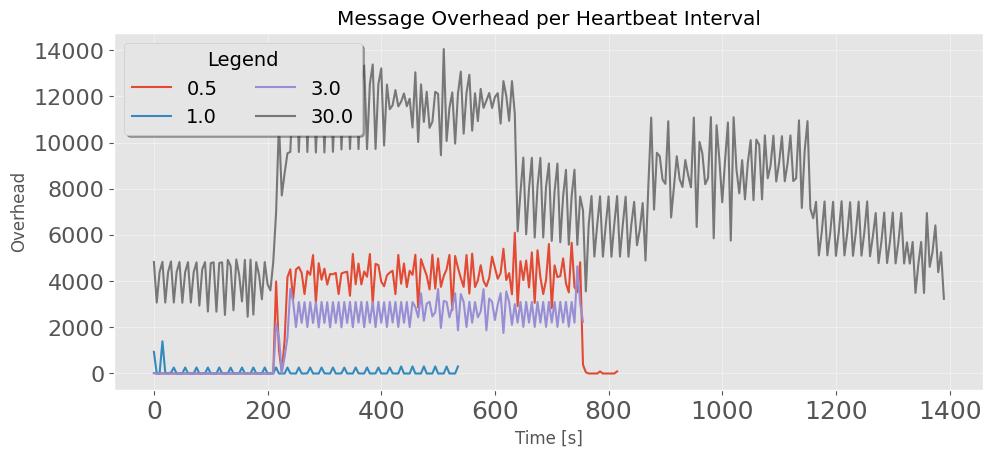

In [38]:
plt.style.use('ggplot')
# kwargs = dict(color=['hotpink'], alpha=0.9)#, density=True)

fig, ax = plt.subplots(constrained_layout=False)
ax.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.gca().set(title='Message Overhead per Heartbeat Interval', ylabel='Overhead', xlabel="Time [s]")

plt.rcParams.update({'font.size': 14})
# plt.hist([x1, x2, x6], **kwargs, label=['GS 1 topic', 'Vanilla', 'Squelching'])
# plt.legend(loc='upper center', bbox_to_anchor=(0.58, 1))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

fig.set_size_inches(11, 4.3)

for interval in np.nditer(intervals):
    aux = intv.loc[intv["interval"] == interval]
    interv = aux["interval"].drop_duplicates().item()
    plt.plot(aux["delta"], aux["mean"], label=interv)

ax.legend(loc="upper left", bbox_to_anchor=[0, 1],
                 ncols=2, shadow=True, title="Legend", fancybox=True)

fig.savefig('./figures/messOverheadInterval.pdf', format='pdf', facecolor='white', edgecolor='none', bbox_inches='tight', dpi=600)
fig.savefig('./figures/messOverheadInterval.png', format='png', facecolor='white', edgecolor='none', bbox_inches='tight', dpi=600)

plt.show()